In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [2]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Defining the model (DeepLabV3+)


#### Reference : https://keras.io/examples/vision/fully_convolutional_network/

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

keras.utils.set_random_seed(27)
tf.random.set_seed(27)

AUTOTUNE = tf.data.AUTOTUNE


In [4]:
NUM_CLASSES = 4
INPUT_HEIGHT = 224
INPUT_WIDTH = 224
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
MIXED_PRECISION = True
SHUFFLE = True

# Mixed-precision setting
if MIXED_PRECISION:
    policy = keras.mixed_precision.Policy("mixed_float16")
    keras.mixed_precision.set_global_policy(policy)


In [5]:
def preprocess_data(image):
    image = keras.applications.vgg19.preprocess_input(image)

    return image


In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Conv2D, Conv2DTranspose, Input, Activation, MaxPooling2D, Add, BatchNormalization, Reshape
from keras.models import Model
from keras.initializers import TruncatedNormal
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [3]:

# https://github.com/JustinHeaton/fully-convolutional-networks/blob/master/FCN32.ipynb
# Reference for model architecture: https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf


from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D, Conv2DTranspose, Input, Activation, Lambda
from keras.models import Model
from keras.initializers import TruncatedNormal
from keras import regularizers
import tensorflow as tf

def get_FCN32(num_classes, input_shape):
    custom_init = TruncatedNormal(stddev=0.01)
    grayscale_input = Input(shape=input_shape)
    rgb_input = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(grayscale_input)
    vgg = VGG16(weights='imagenet', include_top=False, input_tensor=rgb_input)
    pool5 = vgg.get_layer('block5_pool').output
    fc6 = Conv2D(4096, (7, 7), kernel_initializer=custom_init,
                 kernel_regularizer=regularizers.l2(0.01), padding='same')(pool5)
    fc7 = Conv2D(4096, (1, 1), kernel_initializer=custom_init,
                 kernel_regularizer=regularizers.l2(0.01), padding='same')(fc6)
    layer_7_1x1 = Conv2D(num_classes, (1, 1), kernel_initializer=custom_init,
                         kernel_regularizer=regularizers.l2(0.01), padding='same')(fc7)
    upsample1 = Conv2DTranspose(num_classes, (64, 64), strides=32, kernel_initializer=custom_init,
                                kernel_regularizer=regularizers.l2(0.01), padding='same')(layer_7_1x1)
    out_layer = Activation('softmax')(upsample1)
    model = Model(grayscale_input, out_layer)
    return model

input_shape = (224, 224, 1)
model = get_FCN32(4, input_shape)





/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [4]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584

In [5]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [6]:
# Resizing images
SIZE_X = 224
SIZE_Y = 224
# Number of classes for segmentation
n_classes=4

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:

import skimage.io as io
from skimage import transform
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif'
train_images = io.imread(stack_path)

target_size = (224, 224)
resized_train_images = []
for image in train_images[0:300]:
    resized_image = cv2.resize(image, dsize=target_size, interpolation=cv2.INTER_NEAREST)
    #resized_image =  cv2.cvtColor(resized_image, cv2.COLOR_GRAY2BGR)
    #resized_image = preprocess_data(resized_image)
    resized_train_images.append(resized_image)

train_images = np.array(resized_train_images)

print("Shape of the TIFF stack:", train_images.shape)

Shape of the TIFF stack: (300, 224, 224)


In [9]:
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif'
train_masks = io.imread(stack_path)

target_size = (224, 224)
resized_train_masks = []
for image in train_masks[0:300]:
    resized_image = cv2.resize(image, dsize=target_size, interpolation=cv2.INTER_NEAREST)
    #resized_image =  cv2.cvtColor(resized_image, cv2.COLOR_GRAY2BGR)
    #resized_image = preprocess_data(resized_image)
    resized_train_masks.append(resized_image)

train_masks = np.array(resized_train_masks)

print("Shape of the TIFF stack:", train_masks.shape)

Shape of the TIFF stack: (300, 224, 224)


[1 2 3 4]
(224, 224)


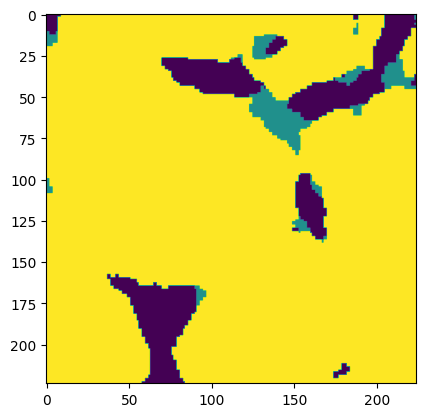

In [10]:
print(np.unique(train_masks[0]))
plt.imshow(train_masks[1])
print(train_masks[0].shape)

In [12]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
print(n, h, w)
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

300 224 224


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [13]:
train_images = np.expand_dims(train_images, axis=3)
train_images.shape

(300, 224, 224, 1)

In [14]:
print("Before: ", train_images)
train_images = normalize(train_images, axis=1)
print("After: ", train_images)

Before:  [[[[117]
   [117]
   [124]
   ...
   [138]
   [138]
   [140]]

  [[117]
   [117]
   [124]
   ...
   [138]
   [138]
   [140]]

  [[122]
   [122]
   [123]
   ...
   [125]
   [125]
   [128]]

  ...

  [[131]
   [131]
   [115]
   ...
   [127]
   [127]
   [116]]

  [[131]
   [131]
   [115]
   ...
   [127]
   [127]
   [116]]

  [[135]
   [135]
   [140]
   ...
   [124]
   [124]
   [120]]]


 [[[ 27]
   [ 27]
   [ 30]
   ...
   [ 59]
   [ 59]
   [ 78]]

  [[ 27]
   [ 27]
   [ 30]
   ...
   [ 59]
   [ 59]
   [ 78]]

  [[ 31]
   [ 31]
   [ 35]
   ...
   [ 48]
   [ 48]
   [ 62]]

  ...

  [[124]
   [124]
   [122]
   ...
   [128]
   [128]
   [128]]

  [[124]
   [124]
   [122]
   ...
   [128]
   [128]
   [128]]

  [[114]
   [114]
   [113]
   ...
   [115]
   [115]
   [122]]]


 [[[130]
   [130]
   [134]
   ...
   [116]
   [116]
   [111]]

  [[130]
   [130]
   [134]
   ...
   [116]
   [116]
   [111]]

  [[124]
   [124]
   [122]
   ...
   [118]
   [118]
   [112]]

  ...

  [[ 39]
   [ 39]
   

In [15]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

(300, 224, 224, 1)


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(270, 224, 224, 1)
(30, 224, 224, 1)
(270, 224, 224, 1)
(30, 224, 224, 1)


In [17]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3]


In [28]:
# Categorical encoding
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
test_masks_cat = to_categorical(y_test, num_classes=n_classes)

y_train_cat = y_train
y_test_cat = y_test


In [29]:
# Class weights to handle class imbalance
class_labels = np.unique(train_masks_reshaped_encoded)
class_counts = [np.sum(train_masks_reshaped_encoded == label) for label in class_labels]
total_samples = len(train_masks_reshaped_encoded)
class_weights = total_samples / (len(class_labels) * np.array(class_counts))

# Print the calculated class weights
print("Class Weights:", class_weights)

Class Weights: [1.92413394 2.8805967  0.33077988 9.09282012]


In [30]:

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

print(IMG_CHANNELS)

print(y_test_cat.shape)

1
(30, 224, 224, 1)


In [31]:
from tensorflow import keras

print(X_train[0].shape)

fcn32s_optimizer = keras.optimizers.AdamW(
    learning_rate=1e-3, weight_decay=1e-4
)

fcn32s_loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer=fcn32s_optimizer,
    loss=fcn32s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=4, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

model.summary()

(224, 224, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 1

In [32]:
history = model.fit(X_train, y_train_cat,
                    epochs=5,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/5
9/9 [==============================] - 52s 3s/step - loss: 54.8140 - mean_io_u_1: 0.1541 - sparse_categorical_accuracy: 0.4440 - val_loss: 24.6240 - val_mean_io_u_1: 0.1481 - val_sparse_categorical_accuracy: 0.4169
Epoch 2/5
9/9 [==============================] - 7s 780ms/step - loss: 20.0037 - mean_io_u_1: 0.1426 - sparse_categorical_accuracy: 0.4039 - val_loss: 16.2940 - val_mean_io_u_1: 0.1385 - val_sparse_categorical_accuracy: 0.3980
Epoch 3/5
9/9 [==============================] - 7s 786ms/step - loss: 14.6265 - mean_io_u_1: 0.1667 - sparse_categorical_accuracy: 0.5146 - val_loss: 12.3678 - val_mean_io_u_1: 0.1886 - val_sparse_categorical_accuracy: 0.6484
Epoch 4/5
9/9 [==============================] - 7s 798ms/step - loss: 10.7328 - mean_io_u_1: 0.1924 - sparse_categorical_accuracy: 0.7215 - val_loss: 8.6763 - val_mean_io_u_1: 0.1867 - val_sparse_categorical_accuracy: 0.7339
Epoch 5/5
9/9 [==============================] - 7s 793ms/step - loss: 7.4721 - mean_io_u_1: 0.

In [39]:
metrics = model.evaluate(X_test, y_test_cat)
print(metrics)
print("Accuracy is = ", (metrics[2] * 100.0), "%")

1/1 [==============================] - 0s 344ms/step - loss: 6.0814 - mean_io_u_1: 0.1855 - sparse_categorical_accuracy: 0.7384
[6.081371784210205, 0.1854867935180664, 0.7384240627288818]
Accuracy is =  73.84240627288818 %


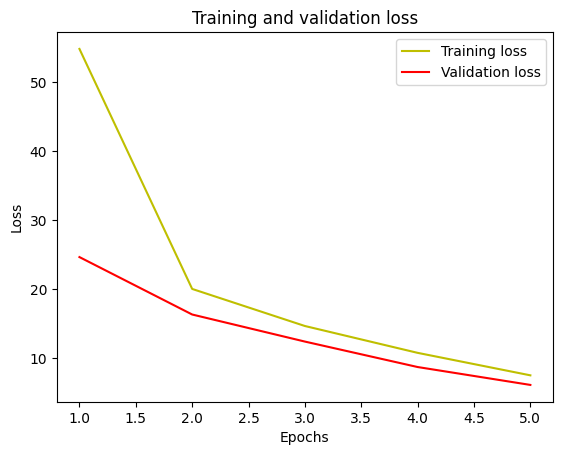

{'loss': [54.81398010253906, 20.00374984741211, 14.62651252746582, 10.73280143737793, 7.472060203552246], 'mean_io_u_1': [0.1540852040052414, 0.14255143702030182, 0.1666625291109085, 0.1924070119857788, 0.19019052386283875], 'sparse_categorical_accuracy': [0.44403934478759766, 0.4039230942726135, 0.5145576000213623, 0.7214533090591431, 0.7531571388244629], 'val_loss': [24.623952865600586, 16.294021606445312, 12.367833137512207, 8.676321983337402, 6.081371784210205], 'val_mean_io_u_1': [0.14811837673187256, 0.13853323459625244, 0.18856988847255707, 0.18668249249458313, 0.1854867935180664], 'val_sparse_categorical_accuracy': [0.4168573319911957, 0.39799970388412476, 0.6483551263809204, 0.7338854074478149, 0.7384240627288818]}


In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(history.history)

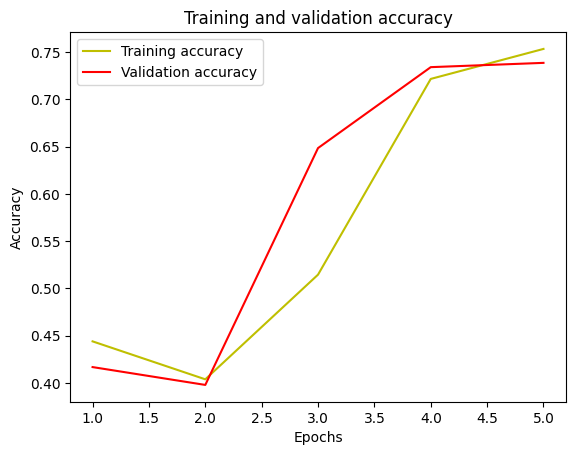

In [44]:
accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
from scipy.ndimage import rotate
def apply_random_rotation(image, mask):
    angle = np.random.uniform(0, 180)
    rotated_image = rotate(image, angle, reshape=False, mode='reflect')
    rotated_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        rotated_channel = rotate(mask[..., channel], angle, reshape=False, mode='reflect')
        rotated_mask[..., channel] = (rotated_channel > 0.5).astype(np.float32)
    return rotated_image, rotated_mask

In [46]:
def apply_horizontal_flip(image, mask):
    flipped_image = np.fliplr(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.fliplr(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [47]:
def apply_vertical_flip(image, mask):
    flipped_image = np.flipud(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.flipud(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [48]:
augmented_image, augmented_mask = apply_vertical_flip(X_train[0], y_train_cat[0])
print("Image Shape: ", augmented_image.shape)
print("Mask Shape: ", augmented_mask.shape)

Image Shape:  (224, 224, 1)
Mask Shape:  (224, 224, 1)


In [49]:
augmented_images = []
augmented_masks = []
for i in range(X_train.shape[0]):
    rot_img, rot_mask = apply_random_rotation(X_train[i], y_train_cat[i])
    h_flip_img, h_flip_mask = apply_horizontal_flip(X_train[i], y_train_cat[i])
    v_flip_img, v_flip_mask = apply_vertical_flip(X_train[i], y_train_cat[i])

    augmented_images.append(rot_img)
    augmented_images.append(h_flip_img)
    augmented_images.append(v_flip_img)

    augmented_masks.append(rot_mask)
    augmented_masks.append(h_flip_mask)
    augmented_masks.append(v_flip_mask)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)
print("Aug Image Shape: ", augmented_images.shape)
print("Aug Mask Shape: ", augmented_masks.shape)

Aug Image Shape:  (810, 224, 224, 1)
Aug Mask Shape:  (810, 224, 224, 1)


In [50]:
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train_cat, augmented_masks), axis = 0)
print("Full Aug Image Shape: ", X_train_aug.shape)
print("Full Aug Mask Shape: ", y_train_aug.shape)

Full Aug Image Shape:  (1080, 224, 224, 1)
Full Aug Mask Shape:  (1080, 224, 224, 1)


In [51]:
# Increasing the number of epochs from 50 ==> 100
# Using the augmented dataset of images and masks
history_aug = model.fit(X_train_aug, y_train_aug,
                    batch_size = 2,
                    verbose=1,
                    epochs=5,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/5
540/540 [==============================] - 159s 290ms/step - loss: 1.3318 - mean_io_u_1: 0.1476 - sparse_categorical_accuracy: 0.5629 - val_loss: 1.1088 - val_mean_io_u_1: 0.1851 - val_sparse_categorical_accuracy: 0.7401
Epoch 2/5
540/540 [==============================] - 157s 290ms/step - loss: 1.0868 - mean_io_u_1: 0.1480 - sparse_categorical_accuracy: 0.5634 - val_loss: 1.0680 - val_mean_io_u_1: 0.1851 - val_sparse_categorical_accuracy: 0.7402
Epoch 3/5
540/540 [==============================] - 156s 290ms/step - loss: 3.4292 - mean_io_u_1: 0.1533 - sparse_categorical_accuracy: 0.5514 - val_loss: 1.1534 - val_mean_io_u_1: 0.1851 - val_sparse_categorical_accuracy: 0.7402
Epoch 4/5
540/540 [==============================] - 156s 289ms/step - loss: 1.0718 - mean_io_u_1: 0.1420 - sparse_categorical_accuracy: 0.5681 - val_loss: 1.0525 - val_mean_io_u_1: 0.1851 - val_sparse_categorical_accuracy: 0.7402
Epoch 5/5
540/540 [==============================] - 156s 290ms/step - loss:

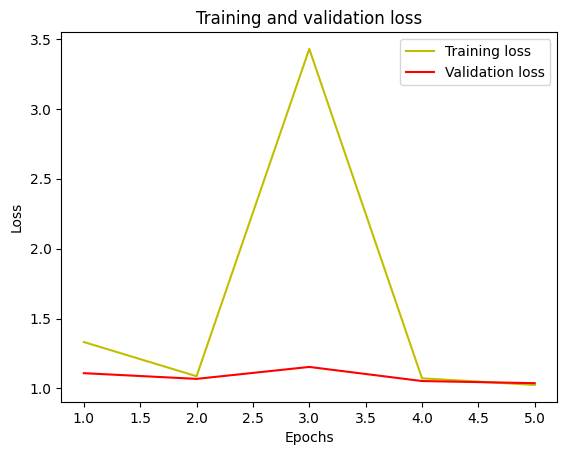

In [52]:
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

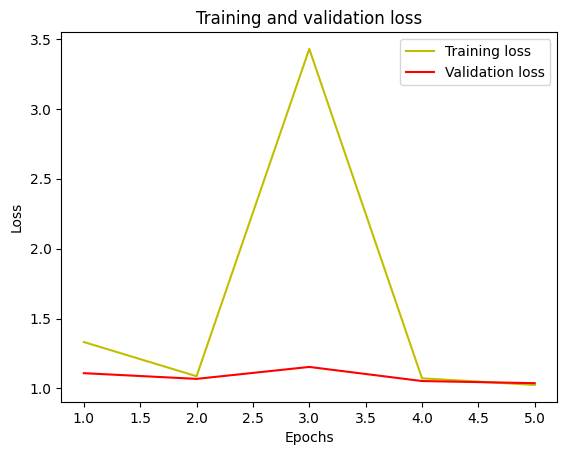

In [53]:
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Comparitive analysis of evaluation metrics of the models on the sandstone dataset

In [54]:
# prediction on training set
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 1s 840ms/step


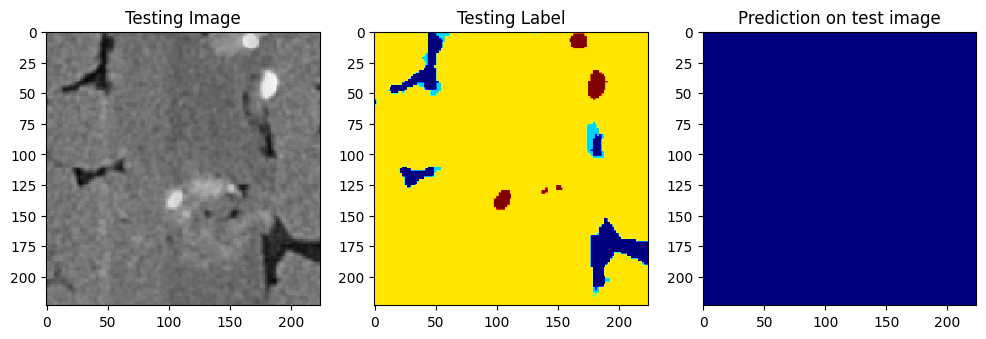

In [55]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [56]:
print("true: ", y_test_cat.shape)
print("pred: ", y_pred.shape)

true:  (30, 224, 224, 1)
pred:  (30, 224, 224, 4)


In [57]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

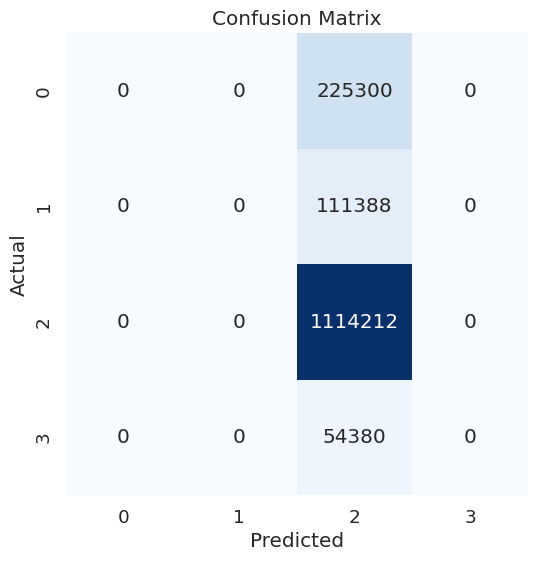

In [58]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [59]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_test, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 74.02%


In [60]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_test, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 74%
Class 3 precision: 0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
# recall
def classwise_recall(y_test, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 100%
Class 3 precision: 0%


In [62]:
# f1-score
def classwise_f1_score(y_test, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 100%
Class 3 precision: 0%


In [63]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.18505062


In [64]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[      0.       0.  225300.       0.]
 [      0.       0.  111388.       0.]
 [      0.       0. 1114212.       0.]
 [      0.       0.   54380.       0.]]
IoU for class1 is:  0.0
IoU for class2 is:  0.0
IoU for class3 is:  0.7402025
IoU for class4 is:  0.0


Training Set

In [65]:
# prediction on training set
y_pred=model.predict(X_train)
y_pred_argmax=np.argmax(y_pred, axis=3)

9/9 [==============================] - 2s 230ms/step


1/1 [==============================] - 0s 30ms/step


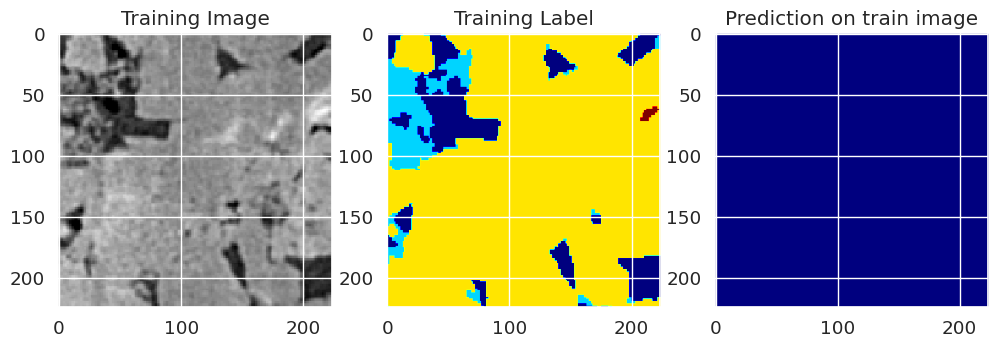

In [66]:
import random
train_img_number = random.randint(0, len(X_train))
train_img = X_train[train_img_number]
ground_truth=y_train[train_img_number]
train_img_norm=train_img[:,:,0][:,:,None]
train_img_input=np.expand_dims(train_img_norm, 0)
prediction = (model.predict(train_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Training Image')
plt.imshow(train_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Training Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on train image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [67]:
print("true: ", y_train_cat.shape)
print("pred: ", y_pred.shape)

true:  (270, 224, 224, 1)
pred:  (270, 224, 224, 4)


In [68]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

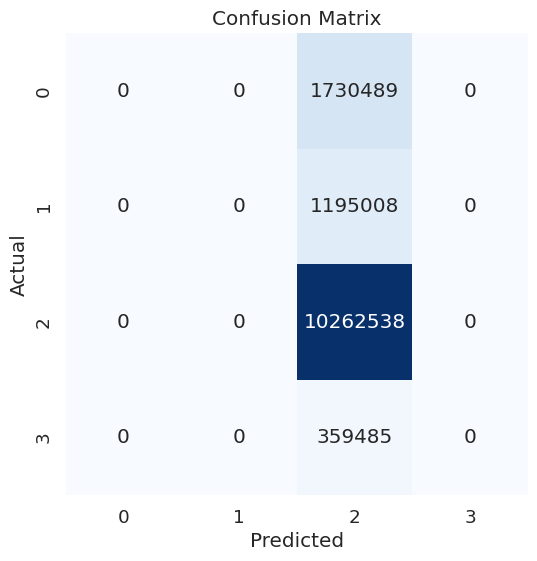

In [69]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_train.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [70]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_train, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 75.75%


In [71]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_train, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 76%
Class 3 precision: 0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
# recall
def classwise_recall(y_train, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 100%
Class 3 precision: 0%


In [73]:
# f1-score
def classwise_f1_score(y_train, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 100%
Class 3 precision: 0%


In [74]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_train[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.18938038


In [75]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[       0.        0.  1730489.        0.]
 [       0.        0.  1195008.        0.]
 [       0.        0. 10262538.        0.]
 [       0.        0.   359485.        0.]]
IoU for class1 is:  0.0
IoU for class2 is:  0.0
IoU for class3 is:  0.7575215
IoU for class4 is:  0.0
